# Phase 3: Producing and Implementing
- Python, Pandas and Matplotlib: Use Python Pandas to read and manipulate data. Create relevant charts
and visualisations using Matplotlib.
- User Interface: How does the user find and generate the data? In a separate Python program, create an
intuitive text-based or graphical user interface (GUI). For full marks, you need a GUI.

## Get Your Data: Acquire any data you need, whether it be from .txt files, .csv files or APIs. For full marks, you need to be using APIs.
I hope FTP counts as an API

In [101]:
# A little options menu thingo :)
import ipywidgets as widgets
from IPython.display import display
import os, shutil

cacheWs = [
    widgets.Checkbox(
        value=False,
        description='Force refresh cache',
        indent=True
    ),
    widgets.HTML(
        value="",
    ),
    widgets.Button(
        description="Refresh status"
    )
]

removeBtn = widgets.Button(
    description="Delete cache"
)

ws = [
    widgets.HTML(
        value="<h1>Caching options</h1>Please note that it <i>will</i> use cached files if they exist in the cache directory unless you specify force refresh.<br>The cache option just caches the files when downloaded, so it's faster but takes up more space.",
    ),
    widgets.Checkbox(
        value=False,
        description='Cache?',
        indent=False
    ),
    widgets.VBox([
        widgets.HBox(cacheWs),
        widgets.HBox([widgets.HTML(value="&nbsp &nbsp &nbsp &nbsp &nbsp &nbsp &nbsp &nbsp &nbsp &nbsp &nbsp &nbsp &nbsp &nbsp &nbsp"),removeBtn])])
]

def isCached():
    return {i: os.path.exists(i) for i in ['./cache/info.zip']}

def RefreshStatus(change):
    cacheWs[1].value = "Cache status: <b>Checking...</b>"
    cacheds = isCached()
    numCached = len([i for i in cacheds if cacheds[i]])
    if numCached == 1:
        cacheWs[1].value = f"Cache status: <b>THERE IS 1 FILE CACHED OUT OF {len(cacheds)}</b>"
    else:
        cacheWs[1].value = f"Cache status: <b>THERE ARE {numCached} FILES CACHED OUT OF {len(cacheds)}</b>"


def removeCache(change):
    shutil.rmtree('./cache')
    os.mkdir('./cache')

ws[1].observe(RefreshStatus, names='value')
cacheWs[2].on_click(RefreshStatus)
removeBtn.on_click(removeCache)

RefreshStatus(None)

display(widgets.VBox(ws))


In [115]:
# Imports
import ftplib, zipfile, io

# Checking the cache
allcached = isCached()
cache = ws[1].value
force = cacheWs[0].value
cacheds = ([] if (not cache) or force else [i for i in allcached if allcached[i]])
fullyCached = len(cacheds) == len(allcached)
print(f"Caching status: {'Force redownloading all cached' if force else 'Fully cached all '+str(len(allcached))+' file'+('s' if len(allcached) != 1 else '') if fullyCached else (str(len(cacheds))+' file'+('s' if len(cacheds) != 1 else '')+' cached out of '+str(len(allcached)) if len(cacheds) > 0 else 'Not cached')}. \
Will download {str(len(allcached)-len(cacheds))} file{'s' if len(allcached)-len(cacheds) != 1 else ''} and will {'not ' if not cache else ''}cache them once downloaded.\n")

files = {
    'info.zip': ('anon/home/ncc/www/change/ACORN_SAT_daily/', 'v2.4-raw-data-and-supporting-information.zip')
}

def getFiles():
    if fullyCached:
        print("Cache has all the files! Using them.")
        return cacheds
    fs = []
    print("Connecting to ftp server...")
    server = ftplib.FTP()
    server.connect("134.178.253.145")
    print("Logging in...")
    server.login()
    for i in files:
        if i in cacheds:
            print(f"Using cached file '{i}'...")
            fs.append(i)
            continue
        print(f"Downloading file '{i}' at ftp://134.178.253.145/{''.join(files[i])} (may take a while)...")
        server.cwd(files[i][0])
        newf = io.BytesIO()
        server.retrbinary('RETR '+files[i][1], newf.write)
        fs.append(newf)
        if cache:
            print(f"Caching file '{i}'...")
            with open(f'./cache/{i}', 'wb') as f:
                f.write(newf.getvalue())
    print("Quitting server connection...")
    server.quit()
    return fs

def extractFiles(fs):
    extracted = []
    for i in fs:
        if isinstance(i, str):
            print(f"Extracting cached file '{i}'...")
        else:
            print(f"Extracting downloaded file {i}...")
        extracted.append(zipfile.ZipFile(i))
    return extracted

fs = getFiles()
print("All files collected! Extracting...")
xtracteds = extractFiles(fs)

print("All files extracted! Collecting data...")
z = xtracteds[0]
dirs = [i for i in z.namelist() if i.startswith('raw-data/') if i != 'raw-data/Raw data.7z' and i != 'raw-data/']
datas = [z.open(i).read().decode() for i in dirs]

print("\nDone!!! :) Thanks for sticking around this long.")

Caching status: Fully cached all 1 file. Will download 0 files and will cache them once downloaded.

Cache has all the files! Using them.
All files collected! Extracting...
Extracting cached file './cache/info.zip'...
All files extracted! Collecting data...

Done!!! :) Thanks for sticking around this long.


In [116]:
print(z.open("readme.txt").read().decode())
# This is the format for the data!

This set of files contains the following:

- homogenised ACORN-SAT data
- raw station data for stations corresponding to the ACORN-SAT locations
- a file (primarysites.txt) with information on which site is the primary site for each ACORN-SAT occasion and for which period of time
(in most cases, there will be two or three primary sites which make up the input data for the overall ACORN-SAT record)
- a summary of adjustments and reference periods and stations. This information is also contained in the station catalogue.
- each of the transfer functions for these adjustments.

Format of raw data files

These file names have the file name hqnewNNNNNN, where NNNNNN is the station number.

Each day of data has the format:

NNNNNN YYYYMMDD  XXX  NNN

where NNNNNN is the station number, YYYYMMDD is the date, XXX is the maximum temperature in tenths of degrees C
(e.g. 251 = 25.1 C) and NNN is the minimum temperature. Missing data is shown as -999.

These data files have been quality controlled

In [207]:
import pandas as pd
from io import StringIO
import re
def clean_data(dat):
    cleaned = re.sub(' +', ',', # Replace the spaces that *were* the deliminers to commas. Theer were not the same number of spaces each time either.
                     re.sub('\r\n......', '\n', dat) # Remove the station number and \r. The station number is the same every time, and returned along with the dataframe.
    ).replace(',\n', '\n' # Because the spaces are a pain and all over the place!
                         )[6:] # The first station number does not get cleaned, so remove it here. 
    df = pd.read_csv(StringIO('Date,MaxTemp,MinTemp\n'+cleaned))
    df = df.drop(df[(df.MaxTemp == -999) | (df.MinTemp == -999)].index) # Remove all missing data coz it's useless
    df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d') # Turn the dates into **real** dates!
    df['MaxTemp'] = df['MaxTemp']/10 # Adjust the temperature because of how it was stored
    df['MinTemp'] = df['MinTemp']/10 # Adjust the temperature because of how it was stored
    return df

print('Cleaning data (may take a short while)...')
alls = {i[:6]: clean_data(i) for i in datas}
print('Done!')

Cleaning data (may take a short while)...
Done!


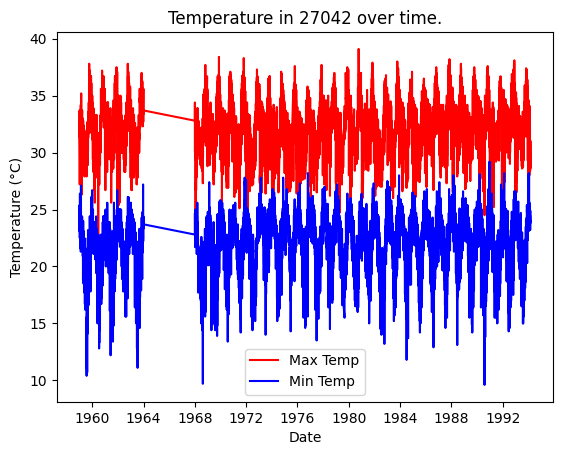

In [214]:
import matplotlib.pyplot as plt
from random import randint
place = list(alls.keys())[randint(0, len(alls)-1)]
# place = '27042'
df = alls[place]
plt.plot(df['Date'], df['MaxTemp'], label='Max Temp', color="red")
plt.plot(df['Date'], df['MinTemp'], label='Min Temp', color="blue")
plt.legend()
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title(f'Temperature in {place} over time.') # TODO: Get real place names
plt.show()
# PLEASE NOTE: If there is a gap, it is because there is no data for that time. This is not an error.
